https://www.kaggle.com/code/vikashrajluhaniwal/sentiment-analysis-using-lstm-in-keras-93-acc

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df = pd.read_csv('Reviews.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Reviews.csv')

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df['Positive'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
clean_df = df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first')
clean_df.shape

(393933, 11)

In [ ]:
df_text = clean_df[['Positive','Text']]

In [ ]:
df_text.head()

,Positive,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Positive / Negative')

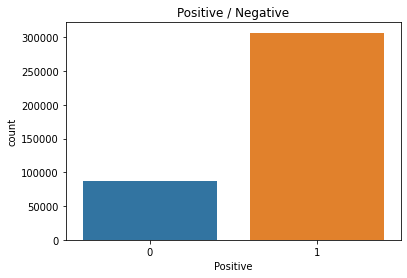

In [ ]:
sns.countplot(df_text['Positive']) #most of the rating is score 5
plt.title('Positive / Negative')

## Preprocessing

In [ ]:
def clean(text):
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [ ]:
#customized stopword list
stop_words = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
            'won', "won't", 'wouldn', "wouldn't","'s","..."])

In [ ]:
from nltk.stem.snowball import SnowballStemmer
snow = SnowballStemmer('english')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def preprocessing(string):
    word_sent = re.sub(r"http\S+", "", string)
    word_sent = clean(word_sent)
    word_sent = re.sub("\S*\d\S*", "", word_sent).strip() #removing words with numerical digits
    word_sent = re.sub('[^A-Za-z]+', ' ', word_sent)   # removing non-word characters
    word_sent = re.sub(r'(\w)\1{2,}',r'\1',word_sent) #removing words of repeated letters
    word_sent = word_tokenize(word_sent.lower())
    word_sent = [word for word in word_sent if word not in stop_words]
    word_sent= ' '.join([snow.stem(word) for word in word_sent])
    word_sent = ' '.join([w for w in word_sent.split() if len(w)>1])
    return word_sent

In [ ]:
df_text['ProcessedText'] = df_text['Text'].astype(str).apply(preprocessing)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_text = df_text.reset_index().drop('index', axis=1)

In [ ]:
df_text

,Positive,Text,ProcessedText
0,1,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,0,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,1,This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,0,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,1,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...
...,...,...,...
393928,1,Great for sesame chicken..this is a good if no...,great sesam chicken good not better restur eat...
393929,0,I'm disappointed with the flavor. The chocolat...,disappoint flavor chocol note especi weak milk...
393930,1,"These stars are small, so you can give 10-15 o...",star small give one train session tri train do...
393931,1,These are the BEST treats for training and rew...,best treat train reward dog good groom lower c...


In [ ]:
df_text.to_csv('df_text_nltk.csv', index=False)